# Project: CXR Anomaly Detectiot 
## Exploratory Data Analysis
### Author: L. Saetta, last update: 10/01/2021

In [1]:
# Need version 11 of seaborn
# Restart kernel after install !
!pip install --upgrade seaborn >> /dev/null

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from itertools import chain
import glob

sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# need version 11 of seaborn
assert sns.__version__ >= '0.11.0'

### Set of functions used to create the various plots

In [3]:
#
# Plotting functions
#
def plot_histo_ages(df):
    BINS = 20
    # limit [0, 100]
    BINRANGE = (0, 100)

    plt.figure(figsize=(20, 6))

    plt.subplot(1,3,1)
    plt.title('All patients')
    sns.histplot(df['Patient Age'], binrange = BINRANGE, bins = BINS);

    condition = df['Patient Gender'] == 'F'
    plt.subplot(1,3,2)
    plt.title('Only female')
    sns.histplot(df.loc[condition, 'Patient Age'], binrange = BINRANGE, bins = BINS);
    
    condition = df['Patient Gender'] == 'M'
    plt.subplot(1,3,3)
    plt.title('Only male')
    sns.histplot(df.loc[condition, 'Patient Age'], binrange = BINRANGE, bins = BINS);

def plot_histo_gender(df):
    print('Total number of patients:', len(df))
    count_sex = df.groupby(['Patient Gender']).size()
    labels = {'F': 'Female', 'M': 'Male'}
    
    for i, key in enumerate(count_sex.keys()):
        print(labels[key], ':', count_sex.values[i])
    
    plt.title('Gender distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    sns.barplot(y = count_sex.values, x  = ['F','M']);
    
def plot_histo_position(df):
    print('Total number of images:', len(df))
    count_view = df.groupby(['View Position']).size()
    
    for i, key in enumerate(count_view.keys()):
        print(key, ':', count_view.values[i])
    print('')

    plt.title('Position View distribution')
    plt.xlabel('View')
    plt.ylabel('Count')
    sns.barplot(y = count_view.values, x  = ['AP','PA']);
    
def plot_histo_diseases(all_diseases, df):
    all_diseases = sorted(list(set(all_labels) - set(['No Finding'])))

    y = df[all_diseases].values

    num_cases = np.sum(y, axis = 0)

    plt.figure(figsize=(8,8))
    plt.title('Number of cases for disease')
    sns.barplot(x = num_cases, y = all_diseases);
    plt.xlabel('N. cases');

def plot_histo_pneumonia(df):
    count_view = df.groupby(['Pneumonia']).size()

    print(count_view)
    print('')

    plt.title('Distribution of pneumonia')
    plt.xlabel('Pneumonia?')
    plt.ylabel('Count')
    sns.barplot(y = count_view.values, x  = [0,1]);
    
def plot_histo_comorbidities(keys, values):
    plt.figure(figsize=(8,8))
    plt.title('Number of comorbitidies cases for Pneumonia')
    sns.barplot(x = keys, y = values);
    plt.xlabel('N. cases');
    plt.ylabel('Disease')

def plot_histo_followup(df):
    plt.title('Distribution of follow-up per patient')
    sns.histplot(df['Follow-up #'], bins=30, binrange=(0,30))

### This function is needed because for many patients we have  more than 1 images for patient. Therefore for several stats we need to aggregate at the patient level

In [4]:
def aggregate_patient(df):
    # build a new dataframe, aggregated at patient level
    # for demographic analysis
    # with cols: Patient ID, gender, age
    # no multiple rows per patient
    patients_id = df['Patient ID'].unique()
    
    patients_df = pd.DataFrame(patients_id, columns = ['Patient ID'])
    
    patients_df['Temp_gender'] = df.groupby(['Patient ID'])['Patient Gender'].agg('unique').values
    # remove the array, there is a single gender value
    patients_df['Patient Gender'] = patients_df['Temp_gender'].map(lambda x: x[0])
    patients_df = patients_df.drop(['Temp_gender'], axis = 1)
    
    patients_df['Patient Age'] = df.groupby(['Patient ID'])['Patient Age'].agg('max').values
    
    return patients_df

## In this Notebook we produce the Full Dataset (NIH CXR-14) EDA

In [5]:
# the file with the complete list of images and their metadata
full_df = pd.read_csv("./metadata/Data_Entry_2017.csv")

# remove useless column
full_df.drop(['Unnamed: 11', 'OriginalImage[Width', 'Height]', 
              'OriginalImagePixelSpacing[x', 'y]'], axis = 1, inplace=True)

print('Number of samples in dataset is:', full_df.shape[0])

Number of samples in dataset is: 112120


In [6]:
# verify that there are no null values 

print('Number of null values for columns:')
full_df.isnull().sum()

Number of null values for columns:


Image Index       0
Finding Labels    0
Follow-up #       0
Patient ID        0
Patient Age       0
Patient Gender    0
View Position     0
dtype: int64

In [7]:
full_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


In [8]:
# for patients demographics we need to work on a dataset 'at patient level'
# with on one rows for patients
patients_df = aggregate_patient(full_df)

### 1. Distribution of Gender

Total number of patients: 30805
Female : 14175
Male : 16630


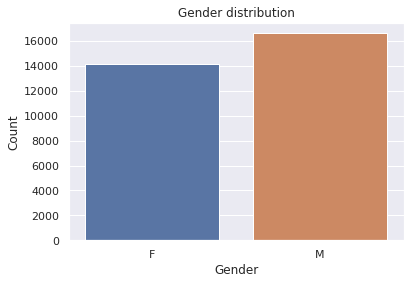

In [9]:
# counts female and male patients
plot_histo_gender(patients_df)

### There is a very slight imbalance with more male patients than female. The difference is slightly bigger than 10%

### 2. Distribution of Ages

We can see that some values for Age are incorrect.

There are 16 records with age > 100



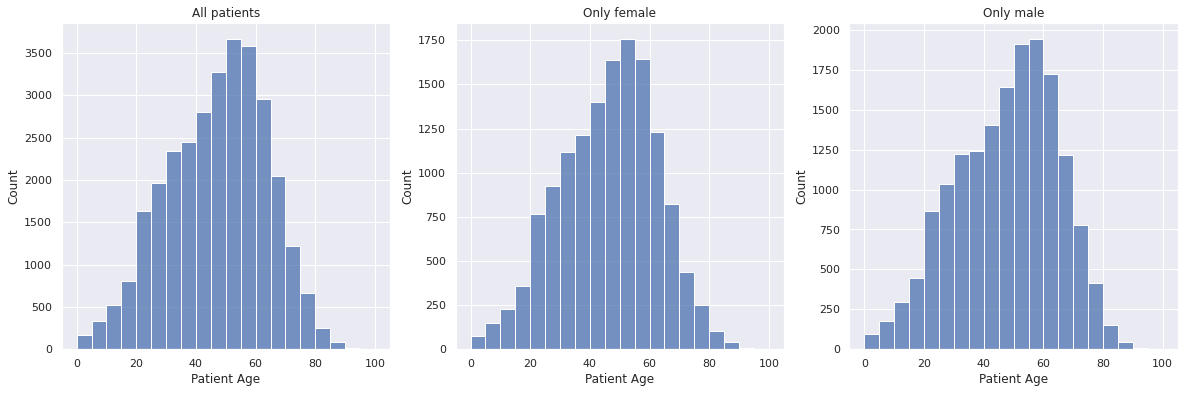

In [10]:
### some values for Age are NOT in range [0, 100]

condition = patients_df['Patient Age'] > 100

elenco_bad_age = list(patients_df.loc[condition, 'Patient ID'])

print('There are %d records with age > 100' %(len(elenco_bad_age)))
print('')

# plot histogram of Ages (consider only 0-100 range)
plot_histo_ages(patients_df)

### This is the Age distribution, for all patients, only female and only male patients. As we can see the large majority is in the range from 10 to 80 years old. The distribution is not significantly differnt from male and female patients:

In [11]:
# check how many are with age < 10 and age > 80

condition = patients_df['Patient Age'] < 10

df_lt10 = patients_df.loc[condition]
perc_lt10 = df_lt10.shape[0] *100./patients_df.shape[0]

condition = patients_df['Patient Age'] > 80

df_gt80 = patients_df.loc[condition]
perc_gt80 = df_gt80.shape[0] *100./patients_df.shape[0]

print('The number of images from patients with Age < 10 is', df_lt10.shape[0], ', only', round(perc_lt10, 1),'%')
print('The number of images from patients with Age > 80 is', df_gt80.shape[0], ', only', round(perc_gt80, 1),'%')

# less than 1.5% of images are with < 10 and > 80

The number of images from patients with Age < 10 is 500 , only 1.6 %
The number of images from patients with Age > 80 is 305 , only 1.0 %


### the percentage of patients with age lower than 10 and greater than 80 is very low, less than 2%
**based on these numbers, we will provide an indication for use: to recommend to use the Model for patients with age within the range: 10-80, a range where we have enough samples for the training and test.**

### 3. Distribution of Patients View Positions (AP, PA)

Total number of images: 112120
AP : 44810
PA : 67310



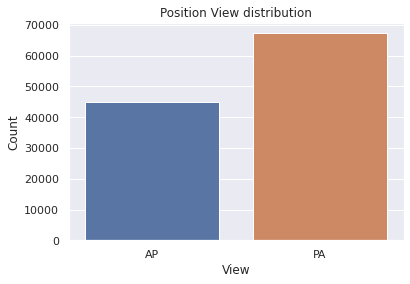

In [12]:
plot_histo_position(full_df)

### In the dataset all images have one of the two view position AP and PA. There is not a significant difference between the two.

### List of distinct diagnosis

In [13]:
all_labels = np.unique(list(chain(*full_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]
print('All Labels are ({}): {}'.format(len(all_labels), all_labels))

All Labels are (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [14]:
# for each label add a column that is 0, 1

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        full_df[c_label] = full_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

### 4. Distribution of diagnosis
We should consider that labels are not exclusive

In [15]:
# compute the dataframe for stats
def compute_stats_df(df):
    num_cases = np.sum(df[all_labels].values, axis = 0).astype(int)
    tot_num_cases = df.shape[0]
    
    stat_df = pd.DataFrame({'disease':all_labels, 'num_cases': num_cases})
    
    # sorting in incresing order of cases
    stat_df = stat_df.sort_values(by=['num_cases'], axis=0, ignore_index=True)
    
    # compute the percentage
    stat_df['perc'] = np.round(stat_df['num_cases']*100./tot_num_cases, 2)
    
    return stat_df

stat_full_df = compute_stats_df(full_df)

stat_full_df.head(15)

,disease,num_cases,perc
0,Hernia,227,0.20
1,Pneumonia,1431,1.28
2,Fibrosis,1686,1.50
3,Edema,2303,2.05
4,Emphysema,2516,2.24
5,Cardiomegaly,2776,2.48
6,Pleural_Thickening,3385,3.02
7,Consolidation,4667,4.16
8,Pneumothorax,5302,4.73
9,Mass,5782,5.16


### In the table it is reported the number of cases and the percentage for each of the 15 different (non exclusive) diagnosis. 

### The number of Pneumonia cases is very low: 1431 out of 112120.
#### Only 1.3% of the total images have pneumonia label. The FULL dataset is heavvily unbalanced

We will need to augment the number of images with label Pneumonia in the training dataset.
See the section "Databases" in the FDA Submission document.

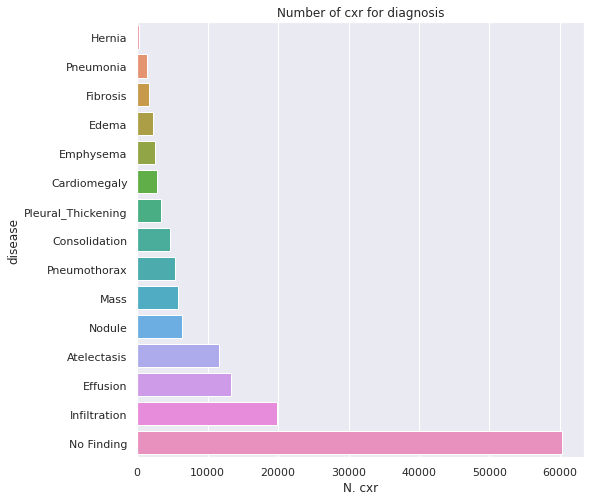

In [16]:
plt.figure(figsize=(8,8))
plt.title('Number of cxr for diagnosis')
sns.barplot(x = stat_full_df['num_cases'], y = stat_full_df['disease']);
plt.xlabel('N. cxr');

### 5. Comorbidities
**Here we compute the Co-Occurrence Matrix: each cell contains the number of cases where both disease (row, column) have been diagnosed**

In [17]:
# Compute CO-OCCURRENCE MATRIX
# on the diagonal we have occurrence of the sìngle disease

all_diseases = sorted(list(set(all_labels) - set(['No Finding'])))

N = len(all_diseases)

co_matrix = np.zeros((N, N))

for i, label1 in enumerate(all_diseases):
    for j, label2 in enumerate(all_diseases):
        co_matrix[i, j] = np.sum(full_df[label1]*full_df[label2])
        
co_matrix_df = pd.DataFrame(data=co_matrix, columns = all_diseases, index= all_diseases, dtype=int)

co_matrix_df.head(15)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,11559,370,1223,221,3275,424,220,40,3264,739,590,496,262,774
Cardiomegaly,370,2776,169,127,1063,44,52,7,587,102,108,111,41,49
Consolidation,1223,169,4667,162,1287,103,79,4,1221,610,428,251,123,223
Edema,221,127,162,2303,593,30,9,3,981,129,131,64,340,33
Effusion,3275,1063,1287,593,13317,359,188,21,4000,1254,912,849,269,996
Emphysema,424,44,103,30,359,2516,36,4,449,215,115,151,23,747
Fibrosis,220,52,79,9,188,36,1686,8,345,117,166,176,11,80
Hernia,40,7,4,3,21,4,8,227,33,25,10,8,3,9
Infiltration,3264,587,1221,981,4000,449,345,33,19894,1159,1546,750,605,946
Mass,739,102,610,129,1254,215,117,25,1159,5782,906,452,71,431


### Comorbities with Pneumonia

From the table above we see that the total number of Pneumonia cases in the dataset is **1431** over **112120** cases.

Looking at the row with label Pneumonia we can discover what are **the most common comorbities with Pneumonia:** 

* Atelectasis 
* Effusion 
* Infiltration 
* Edema**.

See also the plot below.

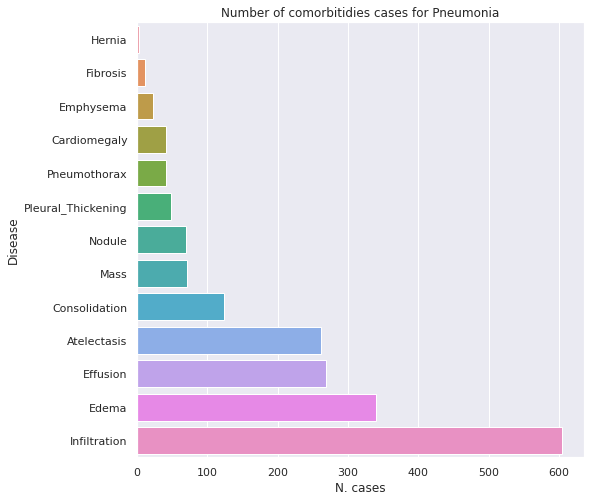

In [18]:
com_pneumonia = co_matrix_df.iloc[12]

# remove pneumonia from the list
com_pneumonia = com_pneumonia.drop('Pneumonia')

# sort in ascending order
com_pneumonia.sort_values(axis=0, inplace=True)

diseases_names = com_pneumonia.keys()
diseases_num_case = com_pneumonia.values

plot_histo_comorbidities(diseases_num_case, diseases_names)

### 6. Number of diseases per patient

How many different diseases have been diagnosed per patient?

Total number of patients is: 30805


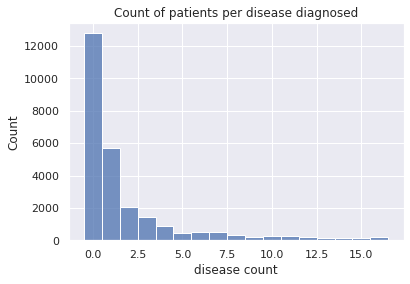

In [19]:
full_gbypid = full_df.groupby('Patient ID').sum()

print('Total number of patients is:', len(full_gbypid))

# transform in a binary count(disease present or not)
for disease in all_diseases:
    full_gbypid[disease] = full_gbypid[disease].map(lambda x: 1 if x > 0 else 0)

# remove useless columns
full_gbypid = full_gbypid.drop(['Patient Age', 'No Finding'], axis = 1)

full_gbypid['disease count'] = full_gbypid.sum(axis = 1)

# now in disease count there is the number of disease for patient

plt.title('Count of patients per disease diagnosed')
sns.histplot(full_gbypid['disease count'], binrange = (0, 16), bins = 16, discrete = True);

#### for most of the patient the diagnosis is NO Finding. More than 5000 patients have 1 disease ... 

### 7. Distribution of Follow-up

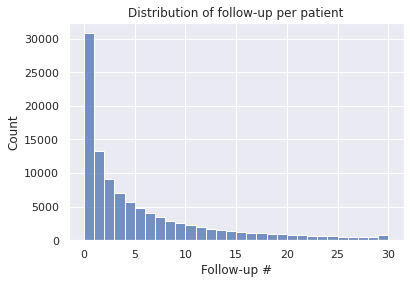

In [20]:
plot_histo_followup(full_df)

## 8. Image Visualization
### Visualization of some random images from the FULL dataset

In [21]:
# build the full path
all_image_list = glob.glob(os.path.join('/data','images*', '*', '*.png'))

all_image_paths = {os.path.basename(x): x for x in all_image_list}

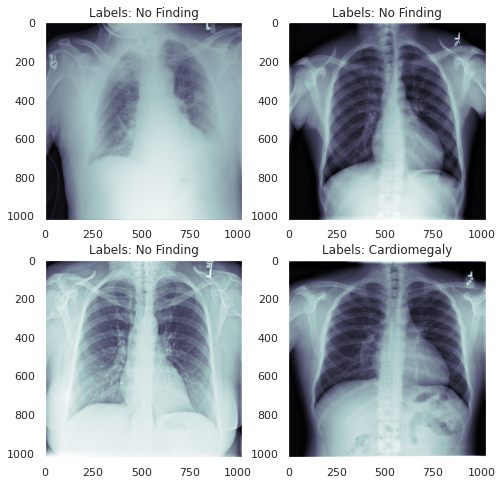

In [22]:
# select four random images from all_image_list
N = 4

indexes = sorted(random.sample(range(0, len(all_image_list)), N))

plt.figure(figsize=(8,8))

for i, index in enumerate(indexes):
    plt.subplot(2, 2, i+1)
    
    full_name = all_image_list[index]
    base_name = os.path.basename(full_name)
    
    img = plt.imread(full_name)
    
    # read the label
    condition = full_df['Image Index'] == base_name
    label = full_df.loc[condition, 'Finding Labels'].values[0]
    
    plt.title('Labels: ' + label)
    plt.imshow(img, cmap='bone')
    plt.grid(b=None)

### above: Images with random labels (majority is No Finding as in the FULL dataset)

### Visualize 4 images with label: pneumonia

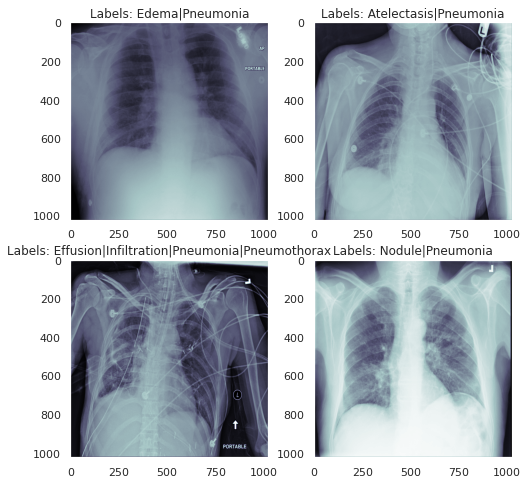

In [23]:
condition = full_df.Pneumonia == 1.0

df_pneumonia = full_df.loc[condition]

samples_pneumonia = df_pneumonia.sample(n=N)

pneumonia_list = samples_pneumonia['Image Index'].values

plt.figure(figsize=(8,8))

for i, base_name in enumerate(pneumonia_list):
    plt.subplot(2, 2, i+1)
    
    full_name = all_image_paths[base_name]
    
    img = plt.imread(full_name)
    
    # read the label
    condition = full_df['Image Index'] == base_name
    label = full_df.loc[condition, 'Finding Labels'].values[0]
    
    plt.title('Labels: ' + label)
    plt.imshow(img, cmap='bone')
    plt.grid(b=None)

### above: images with different diagnosis